In [99]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import torch
import torch.nn as nn


In [100]:
data = scipy.io.loadmat('Xtrain.mat')['Xtrain'].flatten()

## Exploratory analysis / Preprocessing

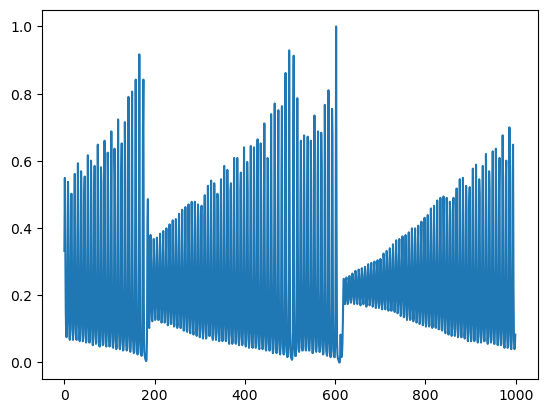

In [101]:
data = data.reshape(-1, 1)
minmax_scaler = MinMaxScaler()
scaled_data = minmax_scaler.fit_transform(data)
plt.plot(scaled_data)

## Building an LSTM

In [102]:
device = 'cpu'

In [103]:
class TimeSeriesDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y 

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
    def __len__(self):
        return len(self.X)

In [104]:
def generate_xy(data, lookback):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i+lookback])
        y.append(data[i+lookback])
    return np.array(X), np.array(y)

In [105]:
def prepare_dataloaders(data, lookback, batch_size=32, split_ratio=0.8):
    X, y = generate_xy(data, lookback)

    split_idx = int(len(X) * split_ratio)
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)

    train_dataset = TimeSeriesDataset(X_train, y_train)
    test_dataset = TimeSeriesDataset(X_test, y_test)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

In [112]:
train_loader, test_loader = prepare_dataloaders(scaled_data, lookback=30, batch_size=32, split_ratio=0.8)

In [113]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers, dropout):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        self.dropout = dropout

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)
        
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
    
model = LSTM(1, 4, 1, 0.25)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [114]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 10 == 9: 
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [115]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [116]:
learning_rate = 0.01
num_epochs = 5
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 10, Loss: 0.004
Batch 20, Loss: 0.005

Val Loss: 0.031
***************************************************

Epoch: 2
Batch 10, Loss: 0.003
Batch 20, Loss: 0.005

Val Loss: 0.029
***************************************************

Epoch: 3
Batch 10, Loss: 0.003
Batch 20, Loss: 0.004

Val Loss: 0.027
***************************************************

Epoch: 4
Batch 10, Loss: 0.003
Batch 20, Loss: 0.004

Val Loss: 0.022
***************************************************

Epoch: 5
Batch 10, Loss: 0.003
Batch 20, Loss: 0.003

Val Loss: 0.009
***************************************************



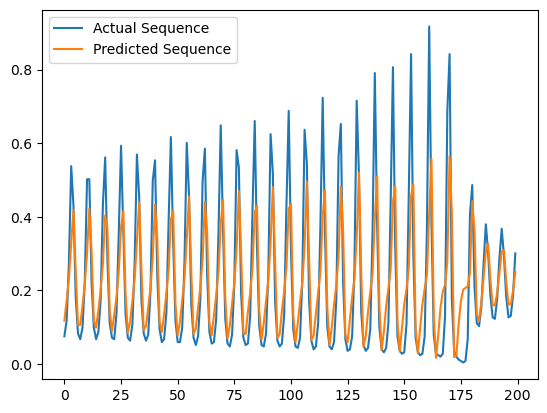

In [117]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train[:200], label='Actual Sequence')
plt.plot(predicted[:200], label='Predicted Sequence')
plt.legend()
plt.show()

In [118]:
lookbacks = [10,20,30]

best_lookback = None
best_val_loss = float('inf')

for lookback in lookbacks:
    print(f'\n Current lookback value: {lookback}')

    train_loader, val_loader = prepare_dataloaders(scaled_data, lookback, batch_size=32)

    model = LSTM(input_size=1, hidden_size=64, num_stacked_layers=2, dropout=0.5).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    loss_function = nn.MSELoss()

    for epoch in range(5):  
        model.train()
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            output = model(x_batch)
            loss = loss_function(output.squeeze(), y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    model.eval()
    val_loss = 0
    count = 0
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            preds = model(x_val)
            loss = loss_function(preds.squeeze(), y_val)
            val_loss += loss.item()
            count += 1
    avg_val_loss = val_loss / count
    print(f'Validation loss: {avg_val_loss:.4f}')

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_lookback = lookback

print(f'Best Lookback: {best_lookback}, with Validation Loss: {best_val_loss:.4f}')



Testing lookback: 800


/Users/linkamitome/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


KeyboardInterrupt: 